In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jacopoferretti_bbc_articles_dataset_path = kagglehub.dataset_download('jacopoferretti/bbc-articles-dataset')

print('Data source import complete.')


![channels4_profile.jpg](attachment:8bb15143-1a5a-4c68-ae85-d04757dcfffe.jpg)

---

### SUMMARY

1. Read the Data
2. Exploratory Data Analysis
3. Topic Modeling with BERTopic

---

In this notebook I am using an updated version of the BBC News Articles dataset, where I have included some extra features. They are the text summary and and text complexity scores. More information can be found in [**Ref. 2**](https://www.kaggle.com/code/jacopoferretti/bbc-news-text-complexity-text-summarization).

With this dataset, I am trying to find the main topics within the BBC News article categories: sport, business, tech, entertainment and politics.

# 1. Read the Data

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

import re
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from cuml.cluster import HDBSCAN
from cuml.manifold import UMAP

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans,AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

from warnings import simplefilter
simplefilter("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [26]:
#!pip install bertopic

import bertopic
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from sentence_transformers import SentenceTransformer

In [7]:
from IPython.display import clear_output
clear_output()

In [8]:
data = pd.read_csv('bbcdataset.csv')

data.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,26,62.17,9.72,It hopes to increase subscribers by offering t...,Its profits were buoyed by one-off gains which...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,17,65.56,9.09,The dollar has hit its highest level against t...,"""I think the chairman's taking a much more san..."
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,14,69.21,9.66,The owners of embattled Russian oil giant Yuko...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits\n\nBritish A...,business,24,62.98,9.86,Looking ahead to its full year results to Marc...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,17,70.63,10.23,Reports in the Wall Street Journal and the Fin...,Shares in UK drinks and food firm Allied Domec...


I am printing the shape of the data (i.e. the number of rows and columns). The dataset has already been cleaned; see [**Ref. 2**](https://www.kaggle.com/code/jacopoferretti/bbc-news-text-complexity-text-summarization).

In [9]:
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns.')

The dataset has 2127 rows and 7 columns.


There is no need to check the null and duplicate values: there are none.

# 2. Exploratory Data Analysis

## 2.1 Article Classes and Their Main Features

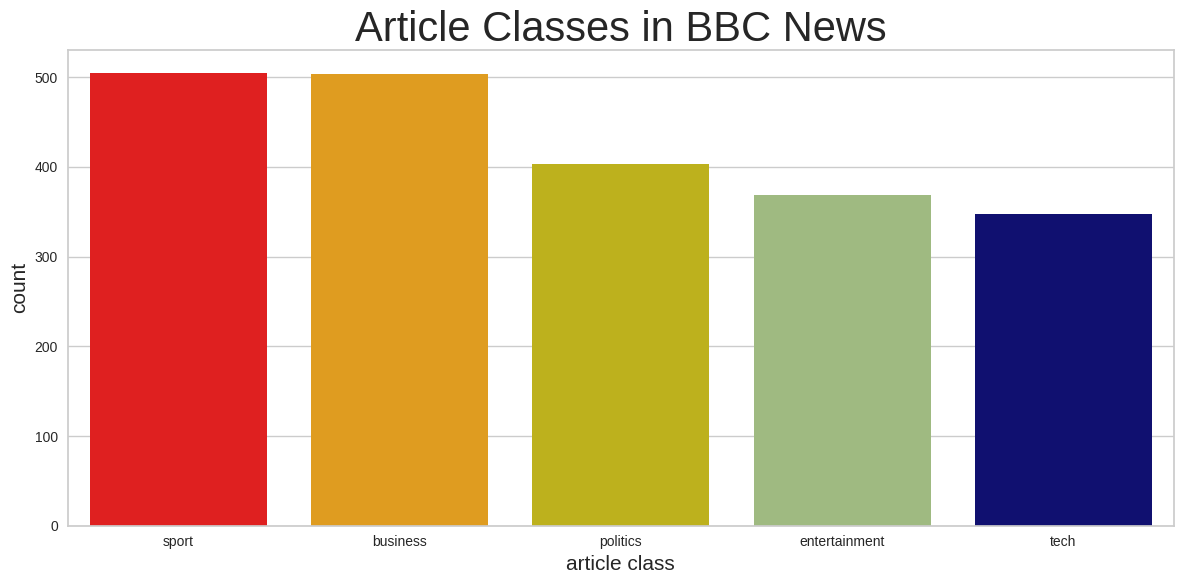

In [10]:
article_count = data.groupby('labels')['labels'].count().reset_index(name='count').sort_values(by='count',ascending=False)

plt.figure(figsize=(12,6))

sns.barplot(data=article_count,x='labels',y='count',palette=['red','orange','y','g','navy'])
plt.xlabel('article class',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.title('Article Classes in BBC News',fontsize=30)

plt.tight_layout()

<Figure size 1200x600 with 0 Axes>

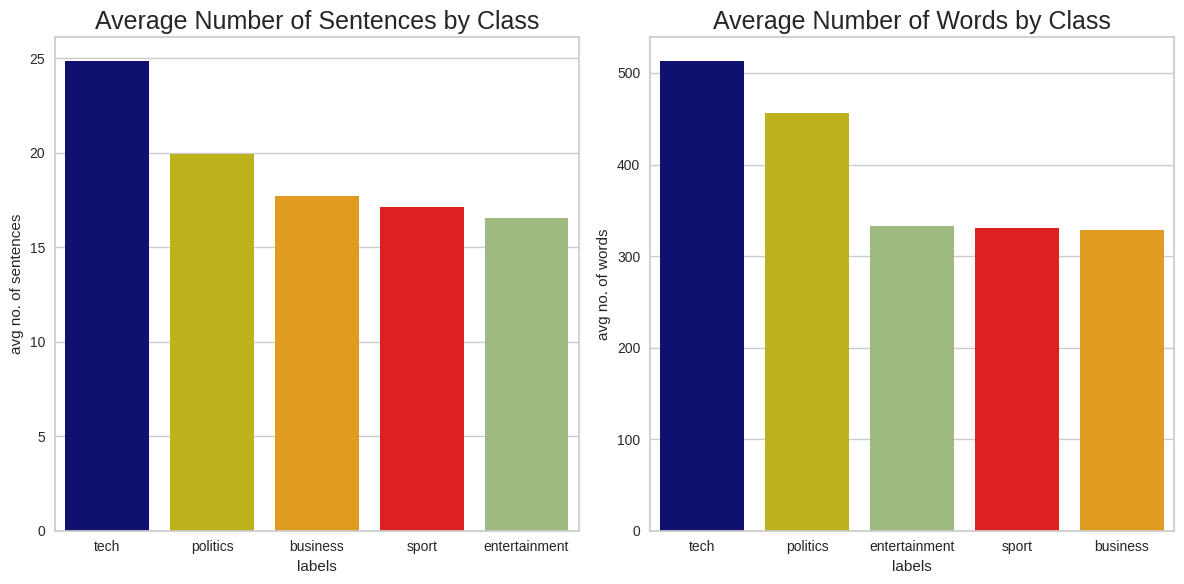

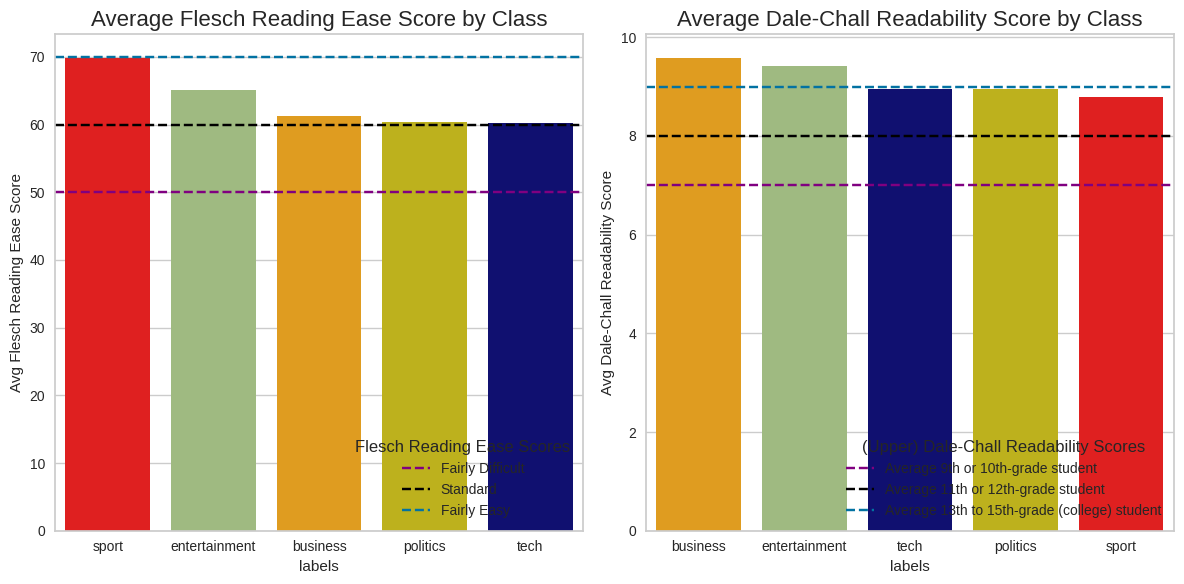

In [11]:
##################################
avg_no_of_sentences = data.groupby('labels')['no_sentences'].mean().reset_index(name='avg no. of sentences').sort_values(by='avg no. of sentences',ascending=False)

data['word count'] = data['text'].str.split().map(lambda x: len(x))

avg_no_of_words = data.groupby('labels')['word count'].mean().reset_index(name='avg no. of words').sort_values(by='avg no. of words',ascending=False)

avg_FleschScore = data.groupby('labels')['Flesch Reading Ease Score'].mean().reset_index(name='Avg Flesch Reading Ease Score').sort_values(by='Avg Flesch Reading Ease Score',ascending=False)

avg_DaleChallScore = data.groupby('labels')['Dale-Chall Readability Score'].mean().reset_index(name='Avg Dale-Chall Readability Score').sort_values(by='Avg Dale-Chall Readability Score',ascending=False)
##################################

fig = plt.figure(figsize=(12,6))
(topfig,bottomfig) = fig.subfigures(2,1)

### Top figures ###
topfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1 = sns.barplot(data=avg_no_of_sentences,x='labels',y='avg no. of sentences',ax=ax1,palette=['navy','y','orange','red','g'])
ax1.set_title('Average Number of Sentences by Class',fontsize=18)

ax2 = sns.barplot(data=avg_no_of_words,x='labels',y='avg no. of words',ax=ax2,palette=['navy','y','g','red','orange'])
ax2.set_title('Average Number of Words by Class',fontsize=18)

plt.tight_layout()

### Bottom figure ###
bottomfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1 = sns.barplot(data=avg_FleschScore,x='labels',y='Avg Flesch Reading Ease Score',ax=ax1,palette=['red','g','orange','y','navy'])
ax1.set_title('Average Flesch Reading Ease Score by Class',fontsize=16)
ax1.axhline(y=50,color='purple',linestyle='--',label='Fairly Difficult')
ax1.axhline(y=60,color='black',linestyle='--',label='Standard')
ax1.axhline(y=70,color='b',linestyle='--',label='Fairly Easy')
ax1.legend(loc='lower right',title='Flesch Reading Ease Scores')

ax2 = sns.barplot(data=avg_DaleChallScore,x='labels',y='Avg Dale-Chall Readability Score',ax=ax2,palette=['orange','g','navy','y','red'])
ax2.set_title('Average Dale-Chall Readability Score by Class',fontsize=16)
ax2.axhline(y=7,color='purple',linestyle='--',
            label="Average 9th or 10th-grade student")
ax2.axhline(y=8,color='black',linestyle='--',
            label="Average 11th or 12th-grade student")
ax2.axhline(y=9,color='b',linestyle='--',
            label="Average 13th to 15th-grade (college) student")
ax2.legend(loc='lower right',title='(Upper) Dale-Chall Readability Scores')

plt.tight_layout()

The plots above describe:
* The average number of sentences and words by article class (sport, politics, tech ...).
* The average Flesch Reading Ease Score by article class. This score describes the ease of readability in a document.
* The average Dale-Chall Readability Score by article class, that returns the grade level of the text using the New Dale-Chall Formula.

## 2.2 Bigram Analysis

I am performing a bigram analysis to find the most frequent 2-word combinations in the text.

In [12]:
def create_corpus_df(data,target):

    corpus=[]
    for x in data[data['labels']==target]['text'].str.split():
        for i in x:
            corpus.append(i)

    return corpus


def get_top_tweet_bigrams(corpus,n=None):

    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

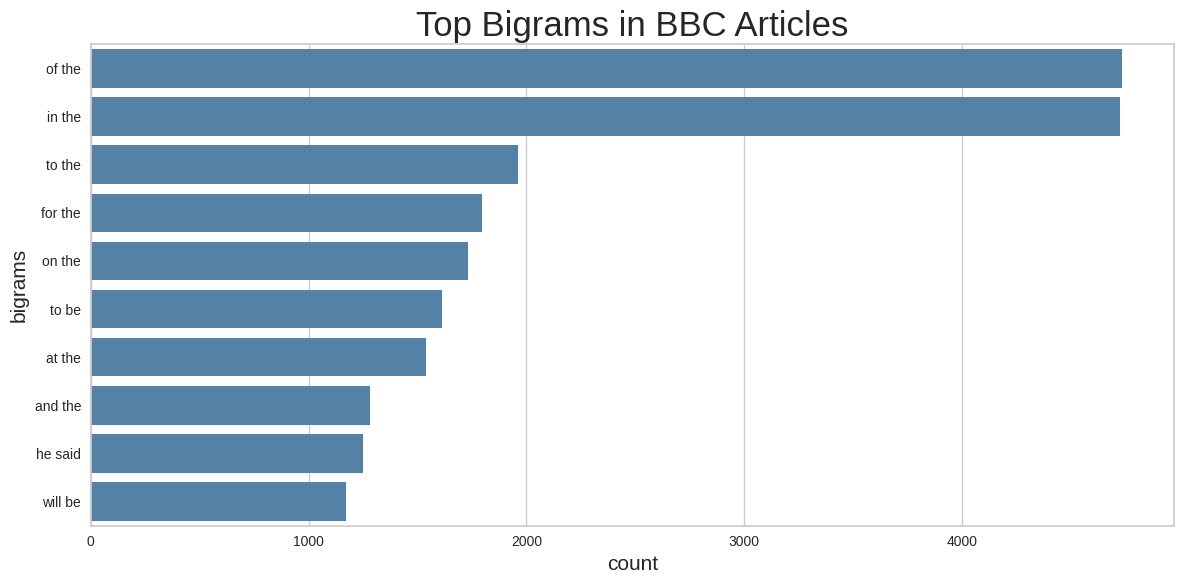

In [13]:
plt.figure(figsize=(12,6))

top_tweet_bigrams = get_top_tweet_bigrams(data['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x,color='steelblue')
plt.xlabel('count',size=15)
plt.ylabel('bigrams',size=15)
plt.title('Top Bigrams in BBC Articles',size=25)

plt.tight_layout()

In [14]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The top bigrams are not so useful. They are mainly combinations of stopwords.

## 2.3 Most Frequent Words by Article Class

Before I look for the most frequent words in each article class, I need to preprocess the text.

In [15]:
nlp = spacy.load("en_core_web_sm")

def clean_text(text):

    '''Make text lowercase, remove text in square brackets, remove links,
    remove punctuation and remove words containing numbers.'''

    text = text.lower()
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    text = re.sub('\[.*?\]','',text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+','',text)
    text = re.sub('\n','',text)
    text = re.sub('\w*\d\w*','',text)
    text = re.sub(r'\d+',' ',text)
    text = re.sub(r'\s+',' ',text,flags=re.I)

    # Stopwods from nltk
    stop = stopwords.words('english')
    # Remove stopwords
    text_split = text.split()
    result = [word for word in text_split if word not in stop]
    text = ' '.join(result)

    # Remove words shorter than 2 characters
    text_split = text.split()
    result = [word for word in text_split if len(word)>2]
    text = ' '.join(result)

    doc = nlp(text)

    cleaned_tokens = []
    for token in doc:
        if token.text not in STOP_WORDS and not token.is_punct and not token.is_space:
            cleaned_tokens.append(token.lemma_)

    cleaned_tokens = ' '.join(cleaned_tokens)

    return text


data['clean text']  = data['text'].apply(clean_text)

In [16]:
### Remove common words ###
common_words = ['said']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

data["clean text"] = data["clean text"].apply(text_cleaning)

data.head(2)

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary,word count,clean text
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,26,62.17,9.72,It hopes to increase subscribers by offering t...,Its profits were buoyed by one-off gains which...,421,sales boost time warner profitquarterly profit...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,17,65.56,9.09,The dollar has hit its highest level against t...,"""I think the chairman's taking a much more san...",384,dollar gains greenspan speechthe dollar hit hi...


<Figure size 1200x600 with 0 Axes>

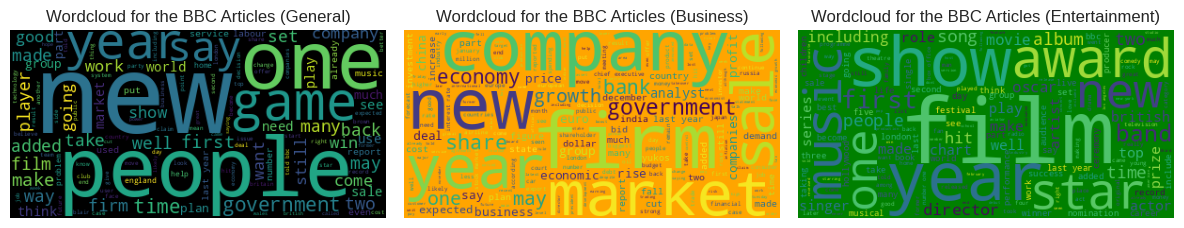

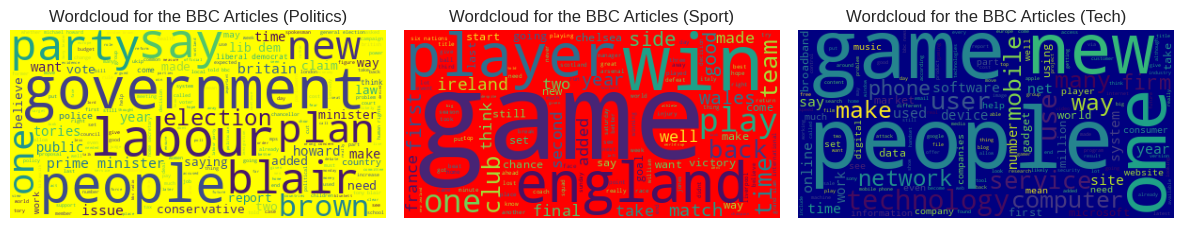

In [17]:
###################################
text = ' '.join(data['clean text'])
wordcloud = WordCloud().generate(text)

text_sport = ' '.join(data.loc[data.labels == 'sport']['clean text'])
wordcloud_sport = WordCloud(background_color="red").generate(text_sport)

text_business = ' '.join(data.loc[data.labels == 'business']['clean text'])
wordcloud_business = WordCloud(background_color="orange").generate(text_business)

text_entertainment = ' '.join(data.loc[data.labels == 'entertainment']['clean text'])
wordcloud_entertainment = WordCloud(background_color="green").generate(text_entertainment)

text_politics = ' '.join(data.loc[data.labels == 'politics']['clean text'])
wordcloud_politics = WordCloud(background_color="yellow").generate(text_politics)

text_tech = ' '.join(data.loc[data.labels == 'tech']['clean text'])
wordcloud_tech = WordCloud(background_color="navy").generate(text_tech)
###################################

fig = plt.figure(figsize=(12,6))
(topfig,bottomfig) = fig.subfigures(2,1)

### Top figures ###
topfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1.imshow(wordcloud)
ax1.axis("off")
ax1.set_title("Wordcloud for the BBC Articles (General)")

ax2.imshow(wordcloud_business)
ax2.axis("off")
ax2.set_title("Wordcloud for the BBC Articles (Business)")

ax3.imshow(wordcloud_entertainment)
ax3.axis("off")
ax3.set_title("Wordcloud for the BBC Articles (Entertainment)")

plt.tight_layout()

### Bottom figures ###
bottomfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1.imshow(wordcloud_politics)
ax1.axis("off")
ax1.set_title("Wordcloud for the BBC Articles (Politics)")

ax2.imshow(wordcloud_sport)
ax2.axis("off")
ax2.set_title("Wordcloud for the BBC Articles (Sport)")

ax3.imshow(wordcloud_tech)
ax3.axis("off")
ax3.set_title("Wordcloud for the BBC Articles (Tech)")

plt.tight_layout()

I am performing the bigram analysis again, but this second time on the 'cleaned' (or preprocessed) text.

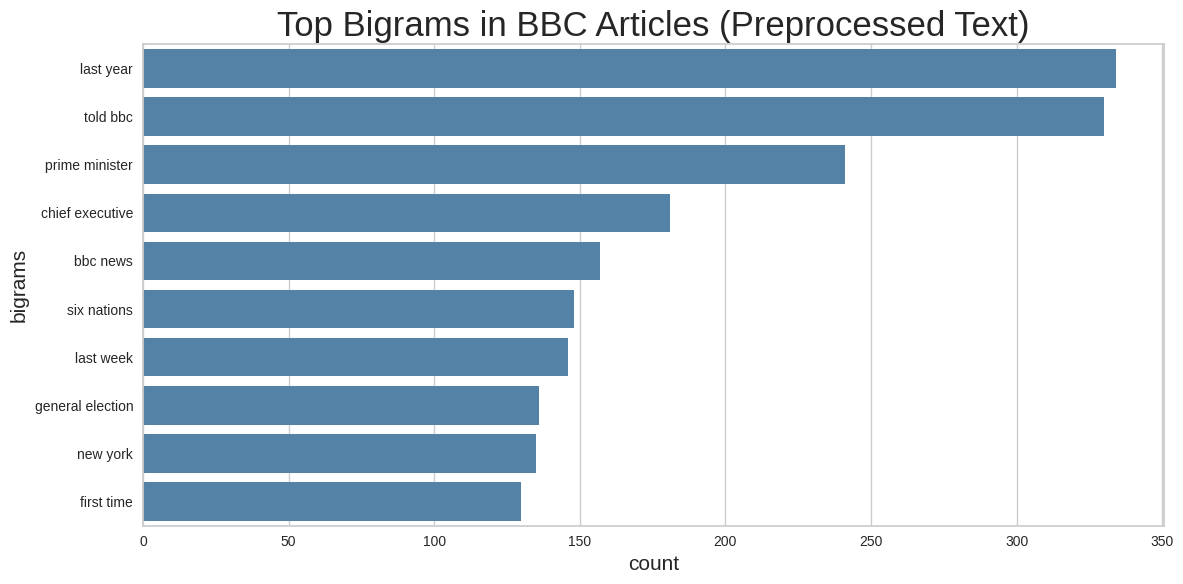

In [18]:
plt.figure(figsize=(12,6))

top_tweet_bigrams = get_top_tweet_bigrams(data['clean text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x,color='steelblue')
plt.xlabel('count',size=15)
plt.ylabel('bigrams',size=15)
plt.title('Top Bigrams in BBC Articles (Preprocessed Text)',size=25)

plt.tight_layout()

The results are much more useful now. They give a hint on the main topics of the BBC articles.

# 3. Topic Modeling with BERTopic

## 3.1 Sport Articles

I will try to find what are the subtopics in the BBC News sport articles by means of BERTopic.

These are the parameters for topic clustering.

In [29]:
# Sentence model params
PRETRAINED_SENTENCE_MODEL = "all-mpnet-base-v2"

# Seeds topics that the model will attempt to converge to
SEED_TOPICS_FLAG = False

# Umap params
UMAP_N_NEIGHBOURS = 15
UMAP_N_COMPONENTS = 5
RANDOM_SEED = 42

# hdbscan params
MIN_CLUSTER_SIZE = 15

# Representation model params
DIVERSITY = 0.5 # val in [0,1] specifying diversity of words in each topic

# Outlier reduction params
OUTLIER_THRESH = 0.2

Now, I am preparing the embeddings and encoding the sport text with them.

In [23]:
from sentence_transformers import SentenceTransformer

docs_sport = data.loc[data.labels == 'sport']['clean text'].to_list()

# Prepare embeddings
sentence_model = SentenceTransformer(PRETRAINED_SENTENCE_MODEL)
embeddings = sentence_model.encode(docs_sport,show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [33]:
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
import umap
import pandas as pd

# -------- Parameters --------
PRETRAINED_SENTENCE_MODEL = "all-mpnet-base-v2"
SEED_TOPICS_FLAG = False
UMAP_N_NEIGHBOURS = 15
UMAP_N_COMPONENTS = 5
RANDOM_SEED = 42
MIN_CLUSTER_SIZE = 15
DIVERSITY = 0.5
OUTLIER_THRESH = 0.2

# -------- Data Preparation --------
# Ensure you already loaded your DataFrame `data` with 'labels' and 'clean text' columns
docs_sport = data.loc[data.labels == 'sport', 'clean text'].to_list()

# -------- Embedding Model --------
sentence_model = SentenceTransformer(PRETRAINED_SENTENCE_MODEL)
embeddings = sentence_model.encode(docs_sport, show_progress_bar=True)

# -------- BERTopic Sub-Models --------
umap_model = umap.UMAP(
    n_neighbors=UMAP_N_NEIGHBOURS,
    n_components=UMAP_N_COMPONENTS,
    random_state=RANDOM_SEED,
    metric='cosine'
)

hdbscan_model = HDBSCAN(
    min_cluster_size=MIN_CLUSTER_SIZE,
    prediction_data=True  # ✅ Important for outlier reduction and probabilities
)

vectorizer_model = CountVectorizer()

representation_model = MaximalMarginalRelevance(diversity=DIVERSITY)

# -------- BERTopic Model --------
model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    embedding_model=sentence_model,
    calculate_probabilities=True,
    verbose=True
)

# -------- Fit the model --------
topics, probs = model.fit_transform(docs_sport, embeddings)

# -------- Optional: Reduce Outliers --------



Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2025-06-04 12:26:11,121 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-04 12:26:12,571 - BERTopic - Dimensionality - Completed ✓
2025-06-04 12:26:12,573 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-04 12:26:12,605 - BERTopic - Cluster - Completed ✓
2025-06-04 12:26:12,611 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-04 12:26:16,976 - BERTopic - Representation - Completed ✓


I am instatiating the model(s) and fitting the topics and their probabilities.

In [34]:
# Instantiate and fit the model
'''from bertopic.representation import MaximalMarginalRelevance
import umap

umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')


umap_model = UMAP(n_components=UMAP_N_COMPONENTS,n_neighbors=UMAP_N_NEIGHBOURS,random_state=RANDOM_SEED)
hdbscan_model = HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE)
vectorizer_model = CountVectorizer()
representation_model = MaximalMarginalRelevance(diversity=DIVERSITY)
model = BERTopic(umap_model=umap_model,hdbscan_model=hdbscan_model,vectorizer_model=vectorizer_model,representation_model=representation_model,embedding_model=PRETRAINED_SENTENCE_MODEL)
topics,probs = model.fit_transform(docs_sport,embeddings)'''


"from bertopic.representation import MaximalMarginalRelevance\nimport umap\n\numap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')\n\n\numap_model = UMAP(n_components=UMAP_N_COMPONENTS,n_neighbors=UMAP_N_NEIGHBOURS,random_state=RANDOM_SEED)\nhdbscan_model = HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE)\nvectorizer_model = CountVectorizer()\nrepresentation_model = MaximalMarginalRelevance(diversity=DIVERSITY)\nmodel = BERTopic(umap_model=umap_model,hdbscan_model=hdbscan_model,vectorizer_model=vectorizer_model,representation_model=representation_model,embedding_model=PRETRAINED_SENTENCE_MODEL)\ntopics,probs = model.fit_transform(docs_sport,embeddings)"

Finally, I can visualize the main topics within the BBC News sport articles.

In [37]:
model.get_topic_freq()

,Topic,Count
2,0,174
3,1,148
4,2,87
0,3,66
1,4,30


In [38]:
model.visualize_topics()

In [39]:
model.visualize_barchart(top_n_topics=4)

It seems that the four main subtopics are:
* Premier League (and football)
* Six Nations (and rugby)
* Athletics and Olympic Games
* Australian Open and tennis

## 3.2 Business Articles

In [40]:
docs_business = data.loc[data.labels == 'business']['clean text'].to_list()

embeddings = sentence_model.encode(docs_business,show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [41]:
topics,probs = model.fit_transform(docs_business,embeddings)

2025-06-04 12:36:00,977 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-04 12:36:03,115 - BERTopic - Dimensionality - Completed ✓
2025-06-04 12:36:03,119 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-04 12:36:03,183 - BERTopic - Cluster - Completed ✓
2025-06-04 12:36:03,189 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-04 12:36:10,664 - BERTopic - Representation - Completed ✓


In [42]:
model.get_topic_freq()

,Topic,Count
5,-1,187
1,0,74
0,1,69
3,2,39
2,3,34
8,4,34
4,5,19
9,6,17
7,7,15
6,8,15


In [43]:
model.visualize_barchart(top_n_topics=6)

The five main topics in business articles are:
* Banks and stocks markets
* Economy and budget
* Russia and Oil
* Airlines
* World Economy

## 3.3 Entertainment Articles

In [44]:
docs_entertainment = data.loc[data.labels == 'entertainment']['clean text'].to_list()

embeddings = sentence_model.encode(docs_entertainment,show_progress_bar=True)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [45]:
topics,probs = model.fit_transform(docs_entertainment,embeddings)

2025-06-04 12:46:02,628 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-04 12:46:03,581 - BERTopic - Dimensionality - Completed ✓
2025-06-04 12:46:03,582 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-04 12:46:03,612 - BERTopic - Cluster - Completed ✓
2025-06-04 12:46:03,619 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-04 12:46:05,490 - BERTopic - Representation - Completed ✓


In [46]:
model.get_topic_freq()

,Topic,Count
1,0,208
2,1,128
0,-1,33


In [47]:
model.visualize_barchart(top_n_topics=6)

The main topics are:
* Movies and series
* Music (bands and records)

## 3.4 Politics Articles

In [48]:
docs_politics = data.loc[data.labels == 'politics']['clean text'].to_list()

embeddings = sentence_model.encode(docs_politics,show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [52]:
topics,probs = model.fit_transform(docs_politics,embeddings)

2025-06-04 12:59:45,607 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-04 12:59:50,350 - BERTopic - Dimensionality - Completed ✓
2025-06-04 12:59:50,359 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-04 12:59:50,525 - BERTopic - Cluster - Completed ✓
2025-06-04 12:59:50,545 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-04 13:00:05,418 - BERTopic - Representation - Completed ✓


In [50]:
model.get_topic_freq()

,Topic,Count
0,0,173
3,-1,112
2,1,61
1,2,36
4,3,21


In [51]:
model.visualize_barchart(top_n_topics=6)

The main topics in politics articles are:
* Taxes, parties and politicians
* Law and rights
* Immigration and asylum

## 3.5 Tech Articles

In [53]:
docs_tech = data.loc[data.labels == 'tech']['clean text'].to_list()

embeddings = sentence_model.encode(docs_tech,show_progress_bar=True)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [54]:
topics,probs = model.fit_transform(docs_tech,embeddings)

2025-06-04 13:08:28,190 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-04 13:08:29,073 - BERTopic - Dimensionality - Completed ✓
2025-06-04 13:08:29,075 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-04 13:08:29,100 - BERTopic - Cluster - Completed ✓
2025-06-04 13:08:29,104 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-04 13:08:33,706 - BERTopic - Representation - Completed ✓


In [55]:
model.get_topic_freq()

,Topic,Count
0,0,166
1,1,79
4,2,61
3,3,21
2,-1,20


In [56]:
model.visualize_barchart(top_n_topics=6)

The main topics of tech articles are:
* Mobiles
* Email and security
* Videogames
* Filesharing and piracy

# 4. Topic Modeling with LDA (Latent Dirichlet Allocation)

## 4.1 Sport Articles

First, I am introducing a function to plot the topics and their top words.

In [57]:
def plot_top_words(model,feature_names,n_top_words=10,color='steelblue'):

    if n_top_words > 5:
        fig,axes = plt.subplots(2,5,figsize=(30,15),sharex=True)
    else:
        fig,axes = plt.subplots(1,5,figsize=(30,15),sharex=True)
    axes = axes.flatten()

    for topic_idx,topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features,weights,height=0.7,color=color)
        ax.set_title(f"Topic {topic_idx +1}",fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both",which="major",labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(f'LDA with {n_top_words} Topics',fontsize=40)

    plt.subplots_adjust(top=0.90,bottom=0.05,wspace=0.90,hspace=0.3)
    plt.show()

Then I am cleaning the text column from the common words and then I am count-vectorizing it.

In [58]:
data_sport = data.loc[data.labels == 'sport']

common_words = ['would','back','also','first','second','new','told','last','want','two','one','six']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

data_sport['clean text'] = data_sport['clean text'].apply(text_cleaning)

In [59]:
vectorizer = CountVectorizer()

vect_sport = vectorizer.fit_transform(data_sport['clean text'])

Now, I can instantiate the LDA model and fit it to the text to get the results.

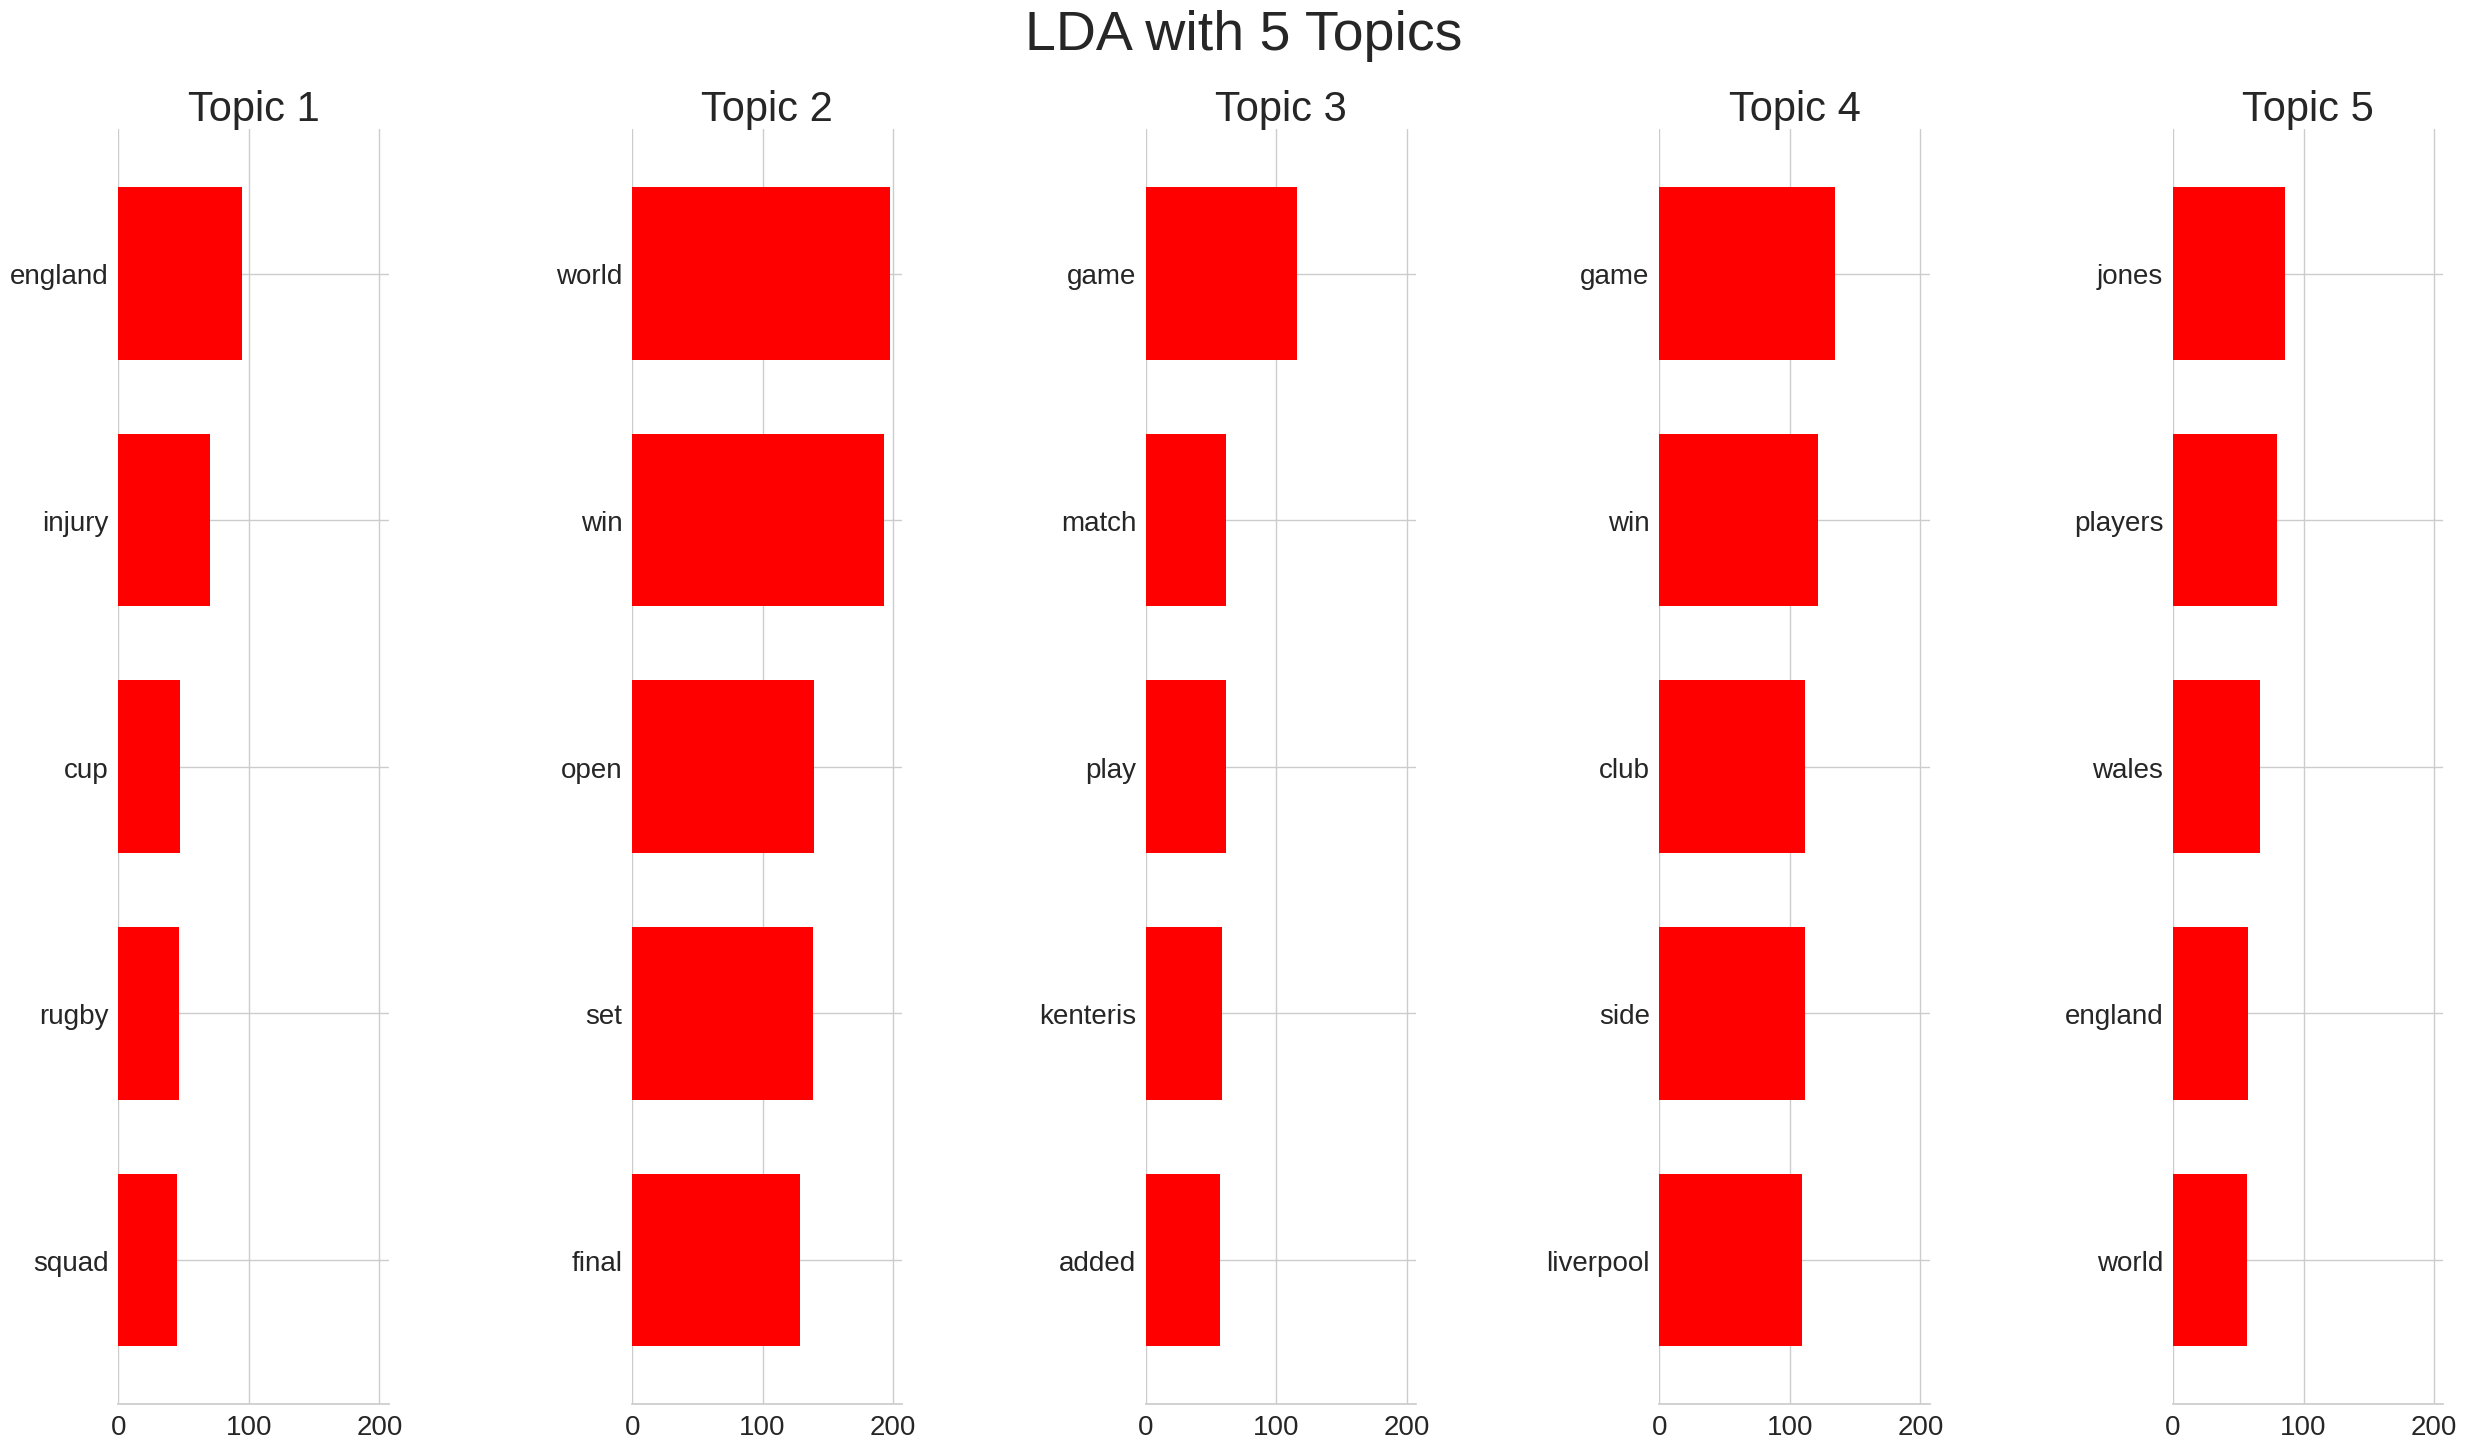

In [60]:
def LDA_text(vec,color,n_components=10):

    # Instantiate LDA and fit to vec
    lda = LatentDirichletAllocation(
    n_components = n_components,
    random_state = 42,
    )

    lda.fit(vec)

    # Plot the results
    feature_names = vectorizer.get_feature_names_out()
    plot_top_words(lda,feature_names,n_components,color=color)


LDA_text(vect_sport,'red',5)

## 4.2 Business Articles

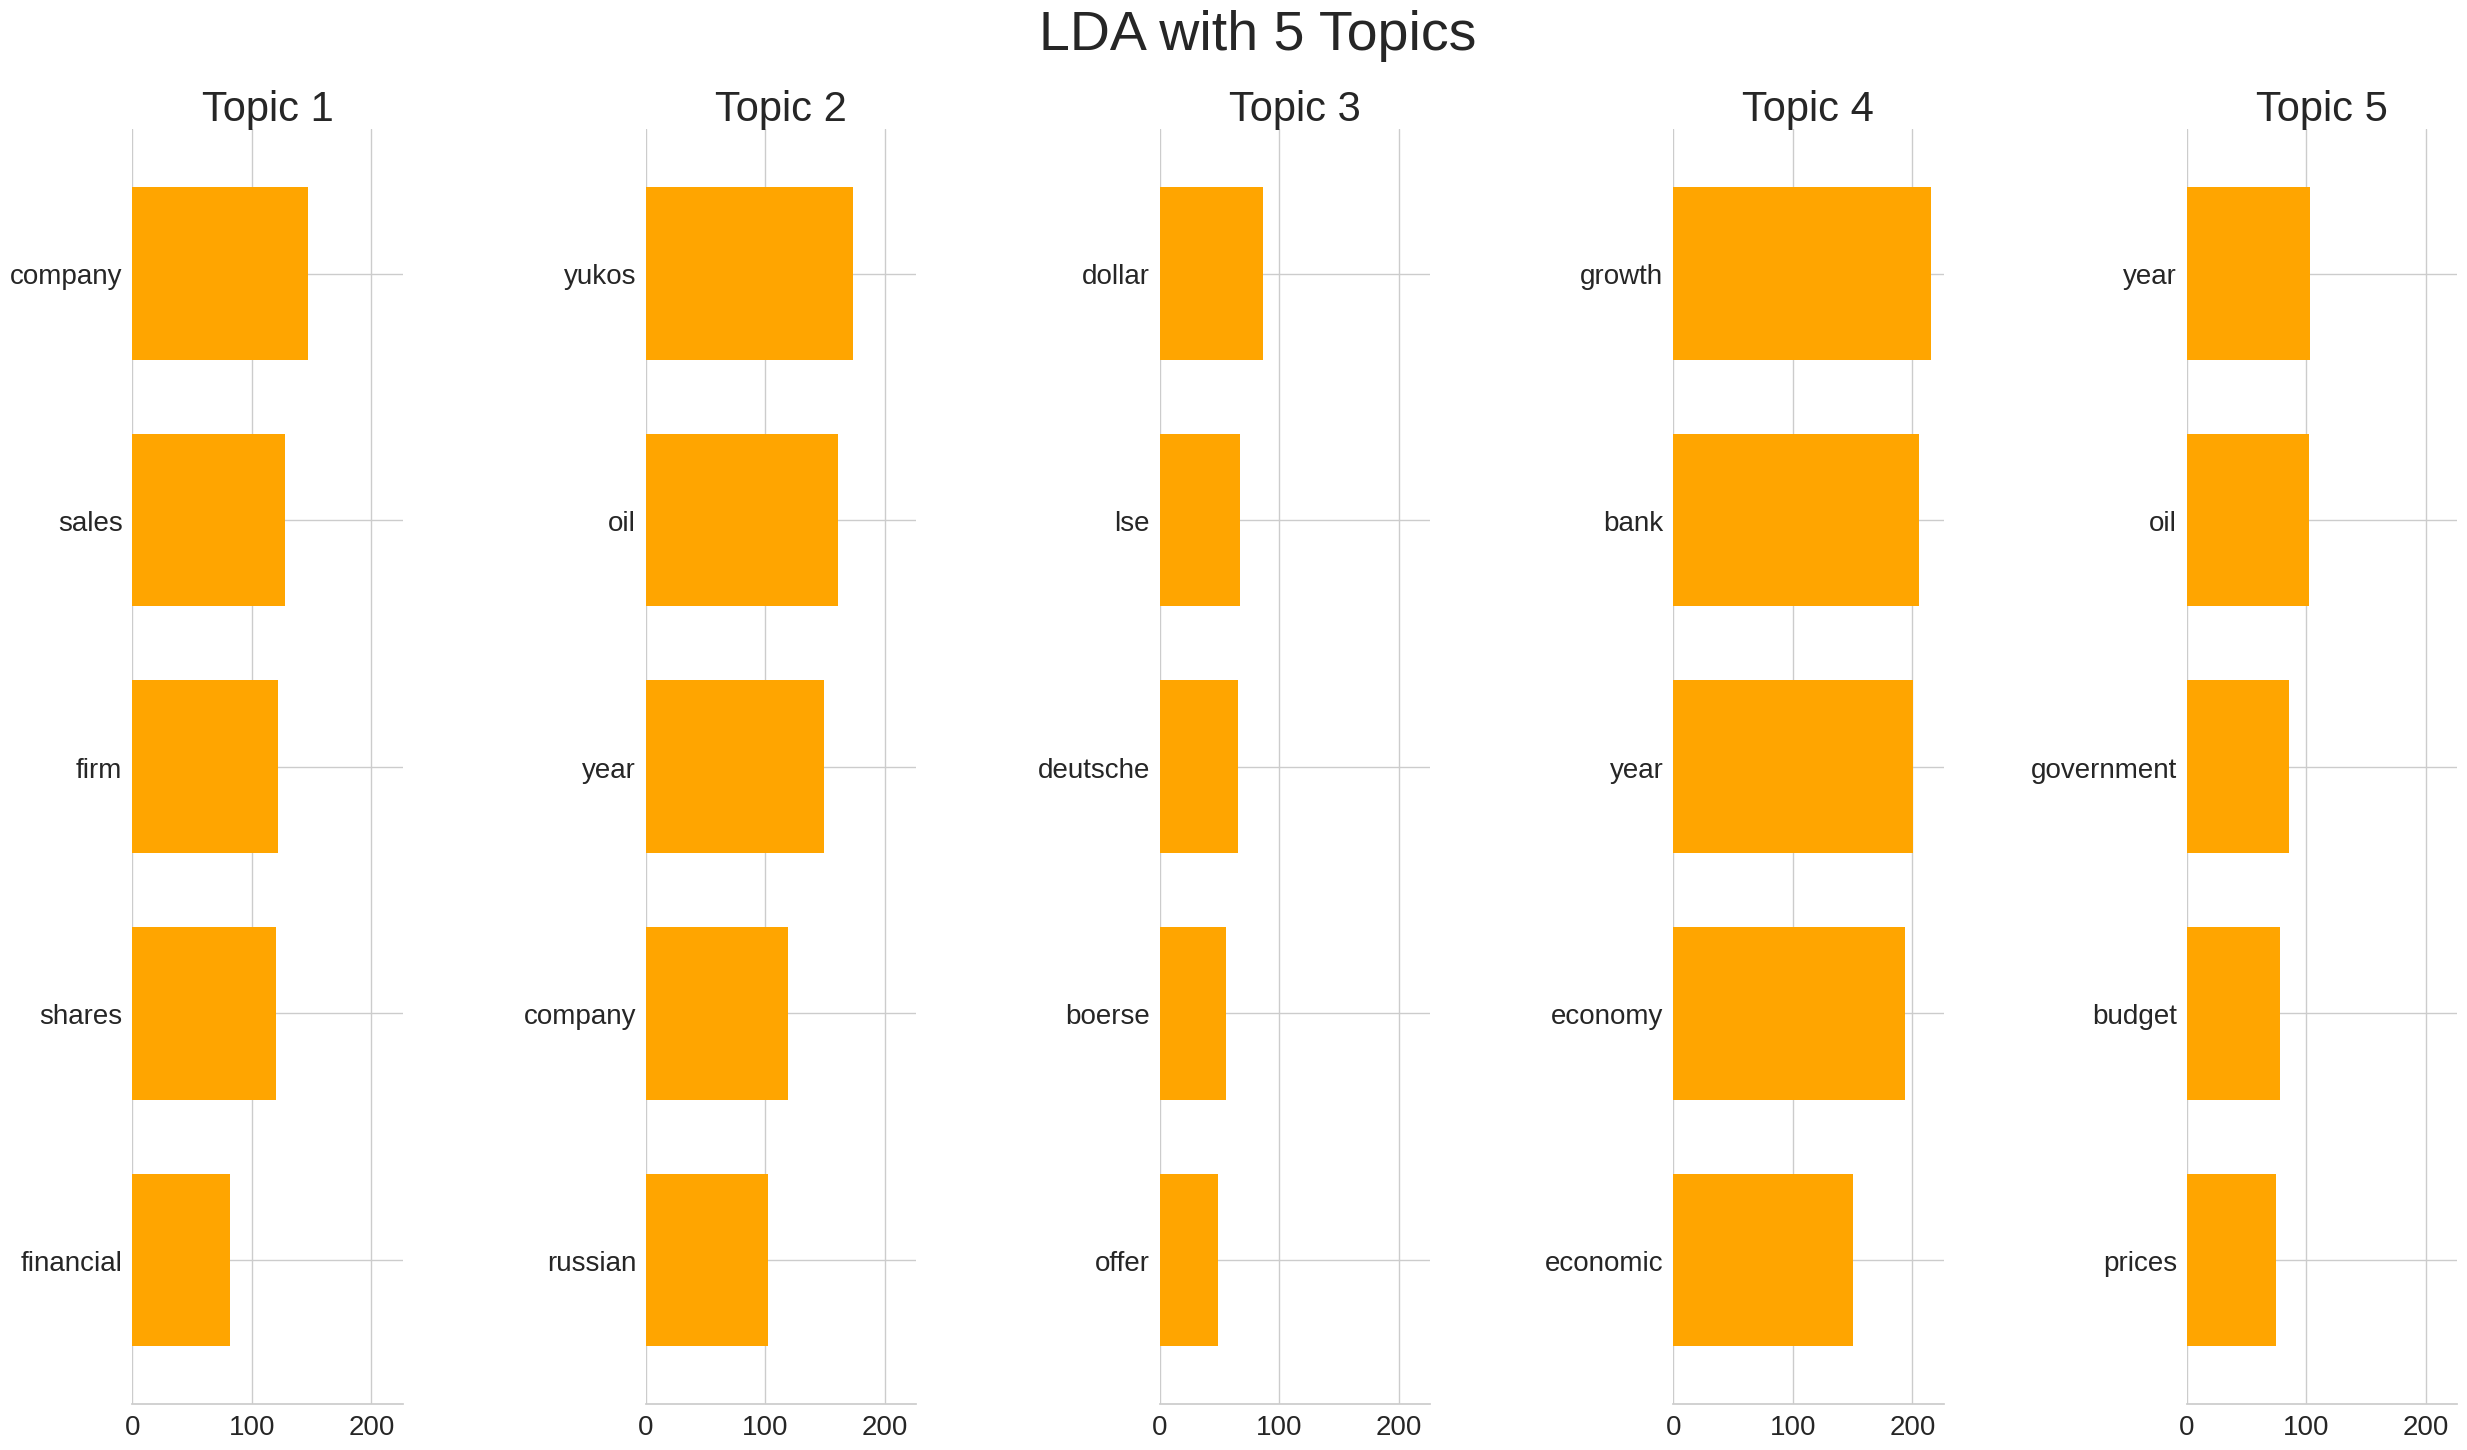

In [61]:
data_business = data.loc[data.labels == 'business']

common_words = ['would','new','also','last','could']

data_business['clean text'] = data_business['clean text'].apply(text_cleaning)

vect_business = vectorizer.fit_transform(data_business['clean text'])

LDA_text(vect_business,'orange',5)

## 4.3 Entertainment Articles

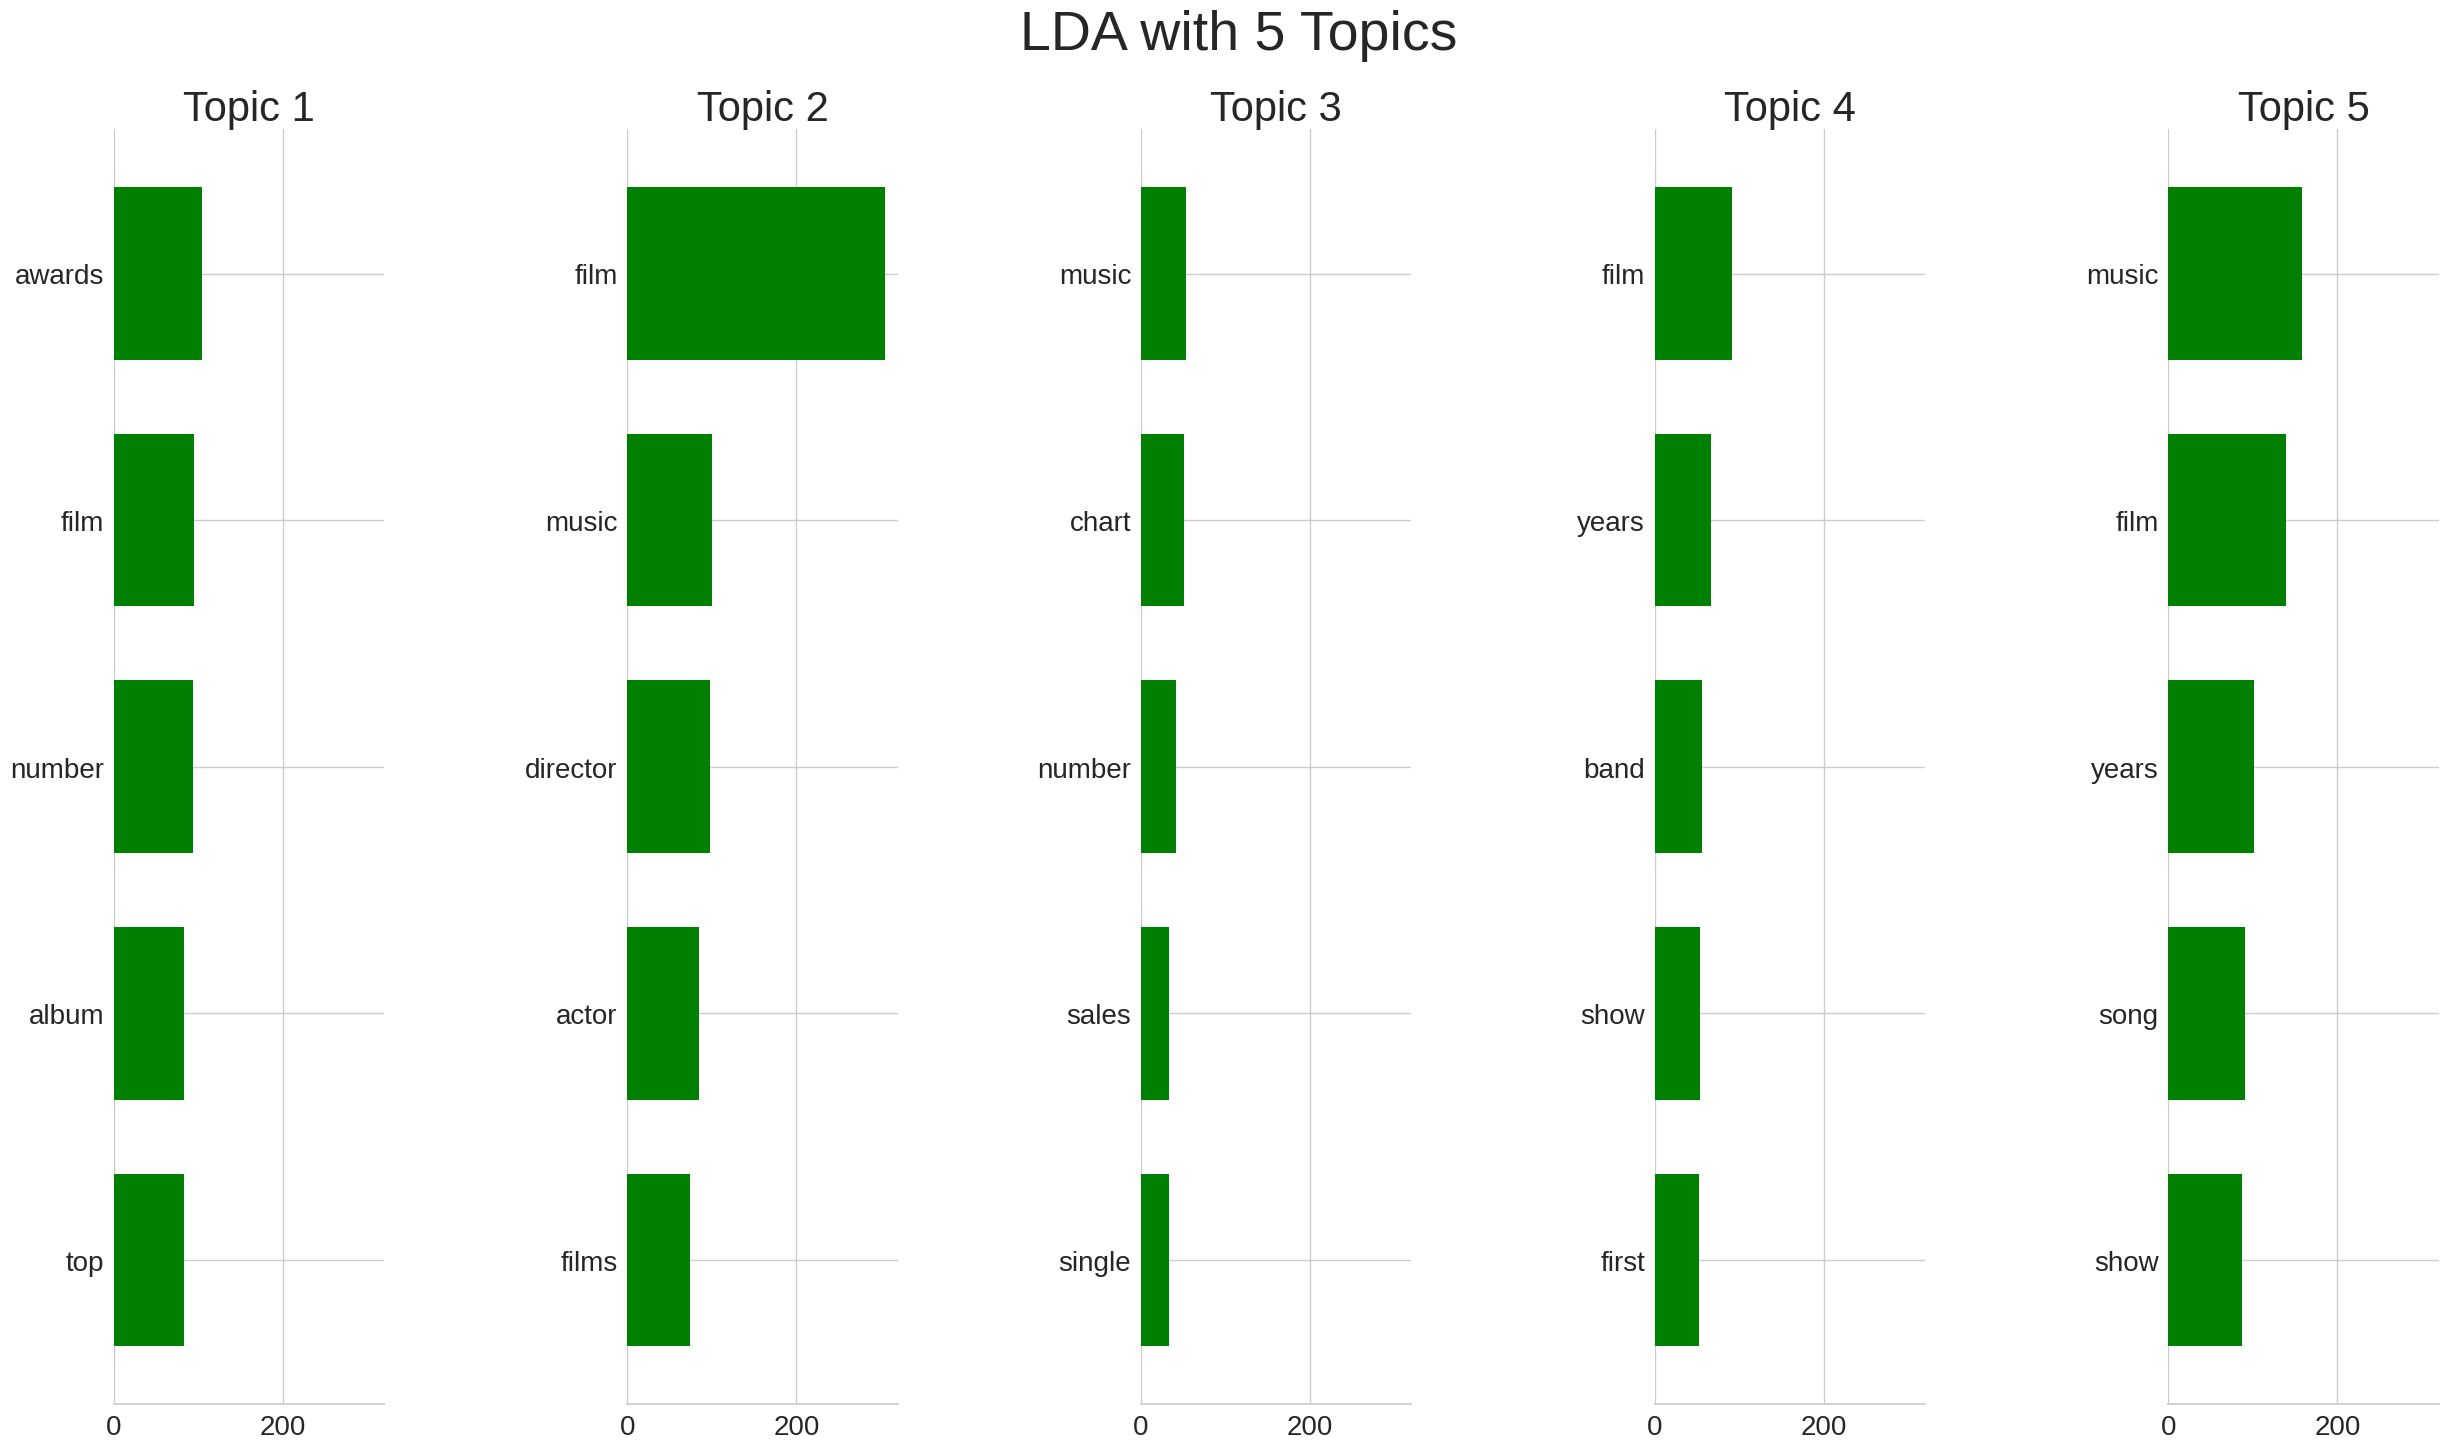

In [62]:
data_entertainment = data.loc[data.labels == 'entertainment']

common_words = ['new','one','last','best','also']

data_entertainment['clean text'] = data_entertainment['clean text'].apply(text_cleaning)

vect_entertainment = vectorizer.fit_transform(data_entertainment['clean text'])

LDA_text(vect_entertainment,'green',5)

## 4.4 Politics Articles

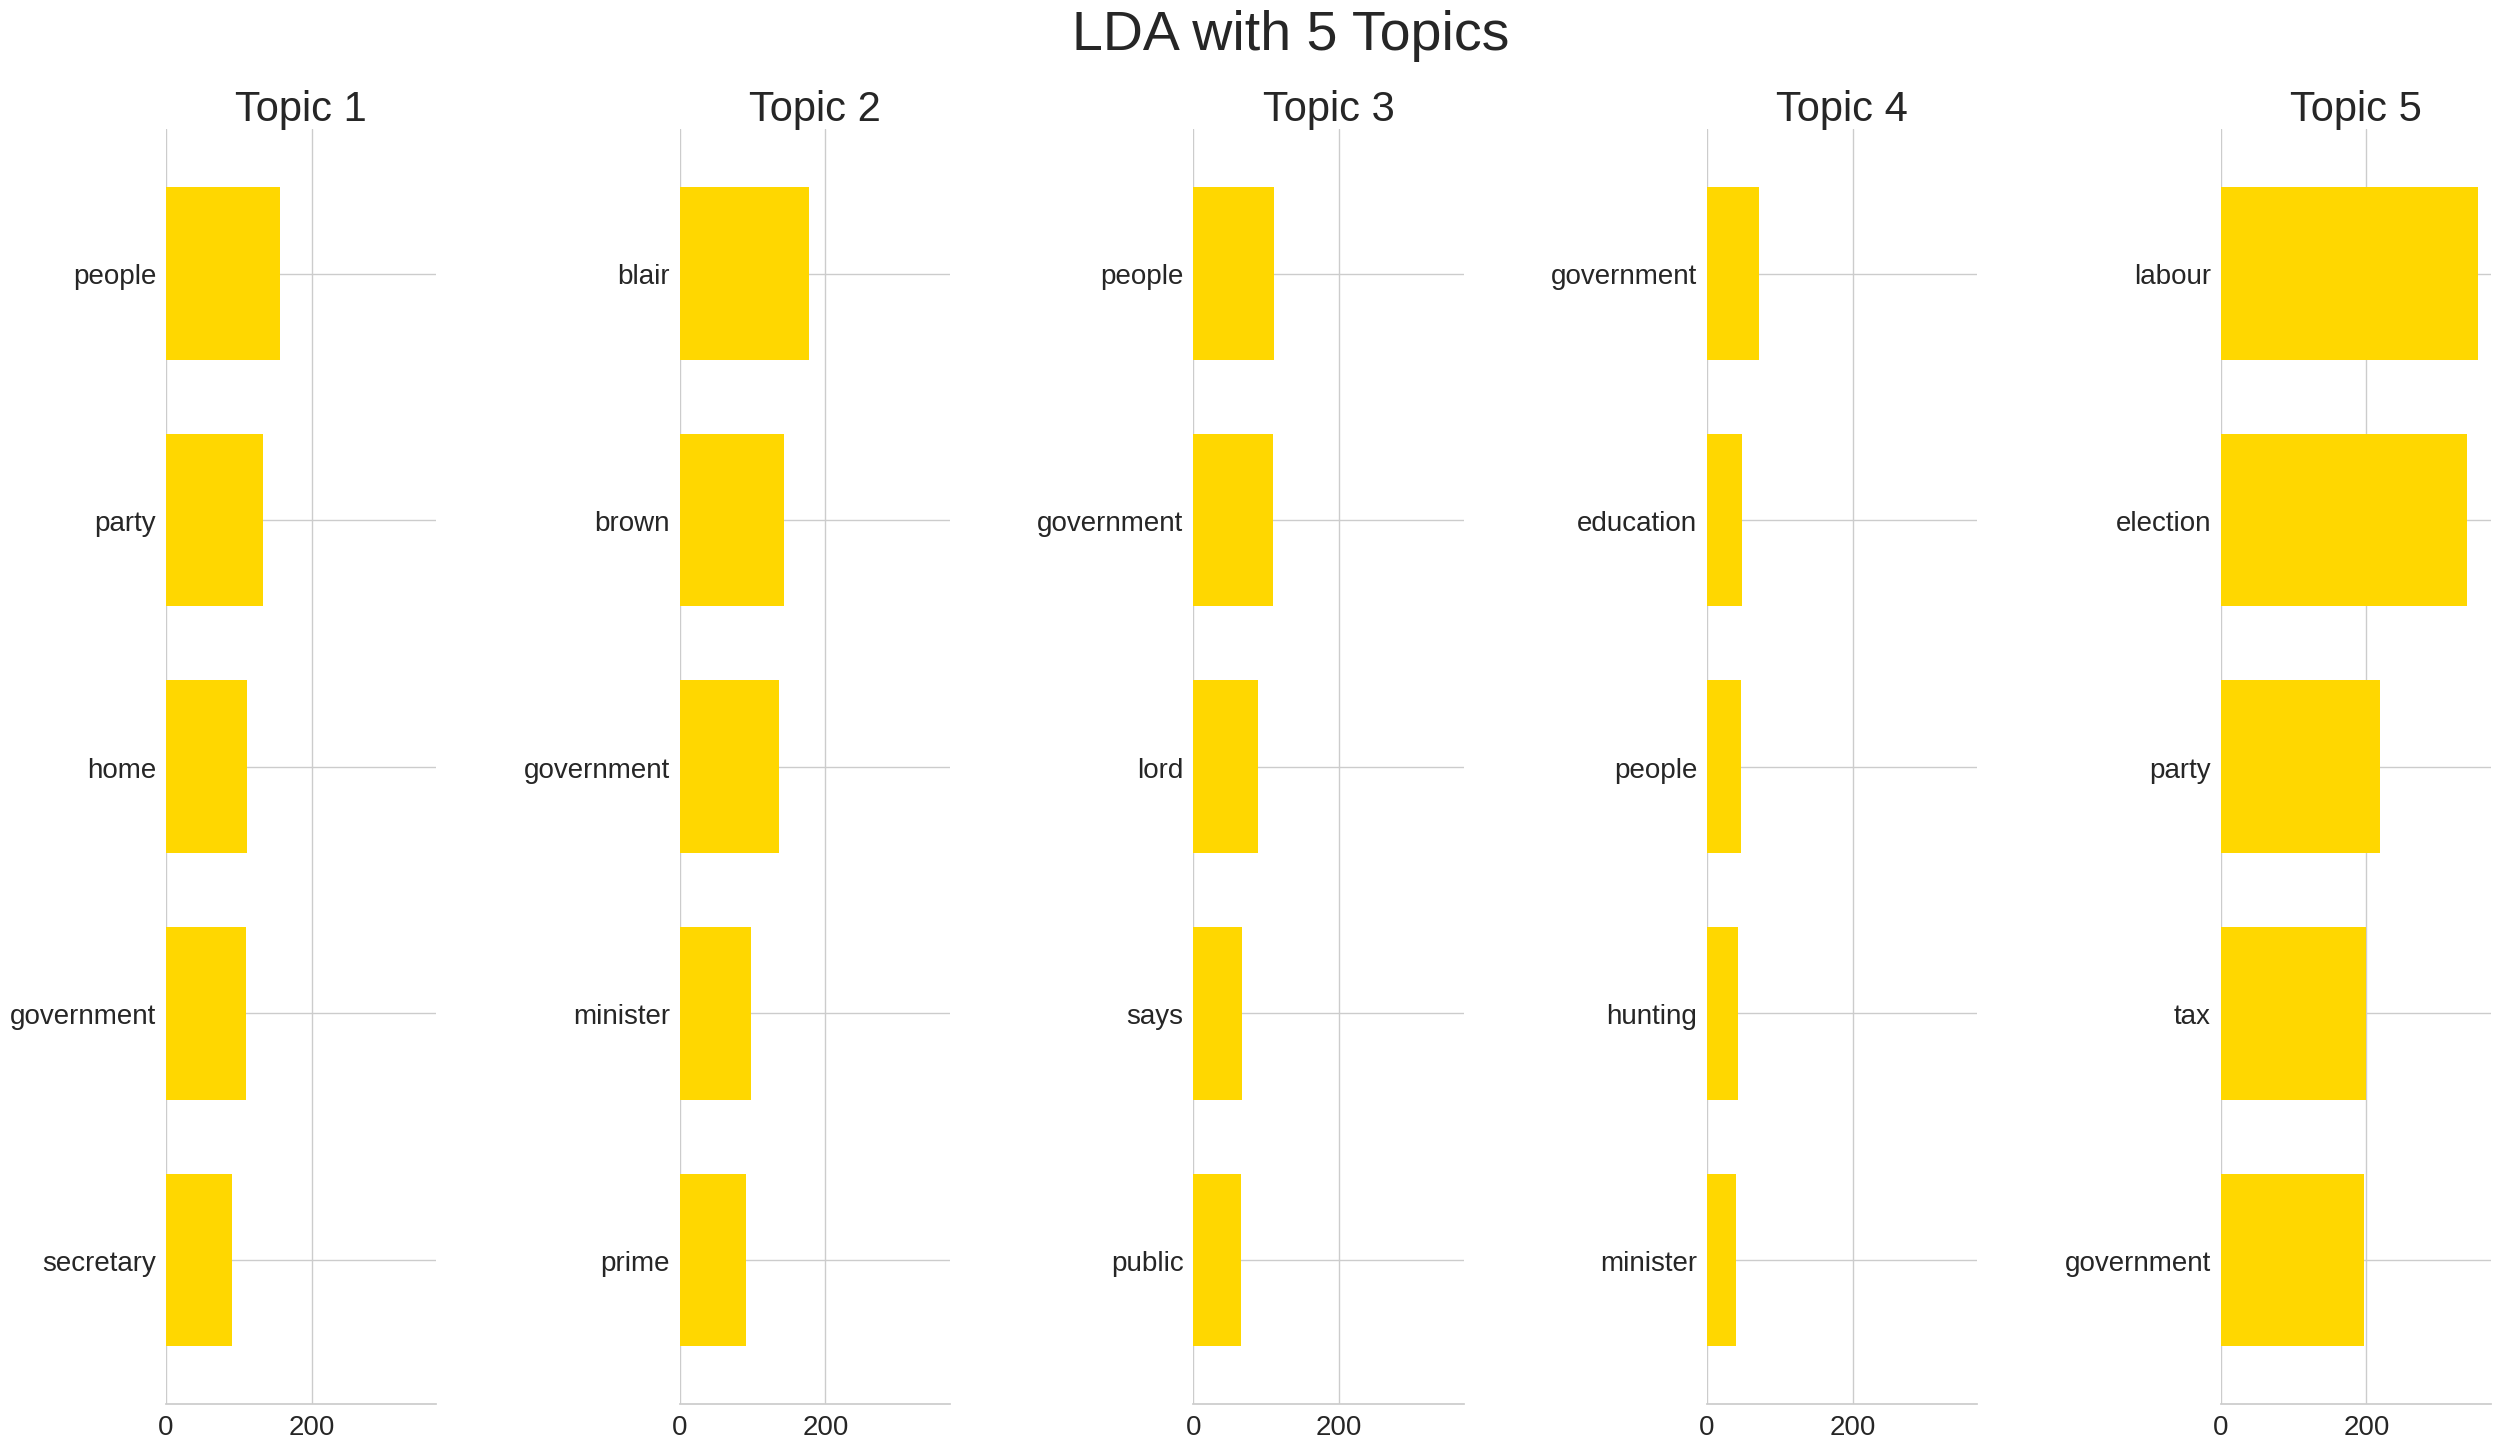

In [63]:
data_politics = data.loc[data.labels == 'politics']

common_words = ['would','also','new','told','could','one']

data_politics['clean text'] = data_politics['clean text'].apply(text_cleaning)

vect_politics = vectorizer.fit_transform(data_politics['clean text'])

LDA_text(vect_politics,'gold',5)

## 4.5 Tech Articles

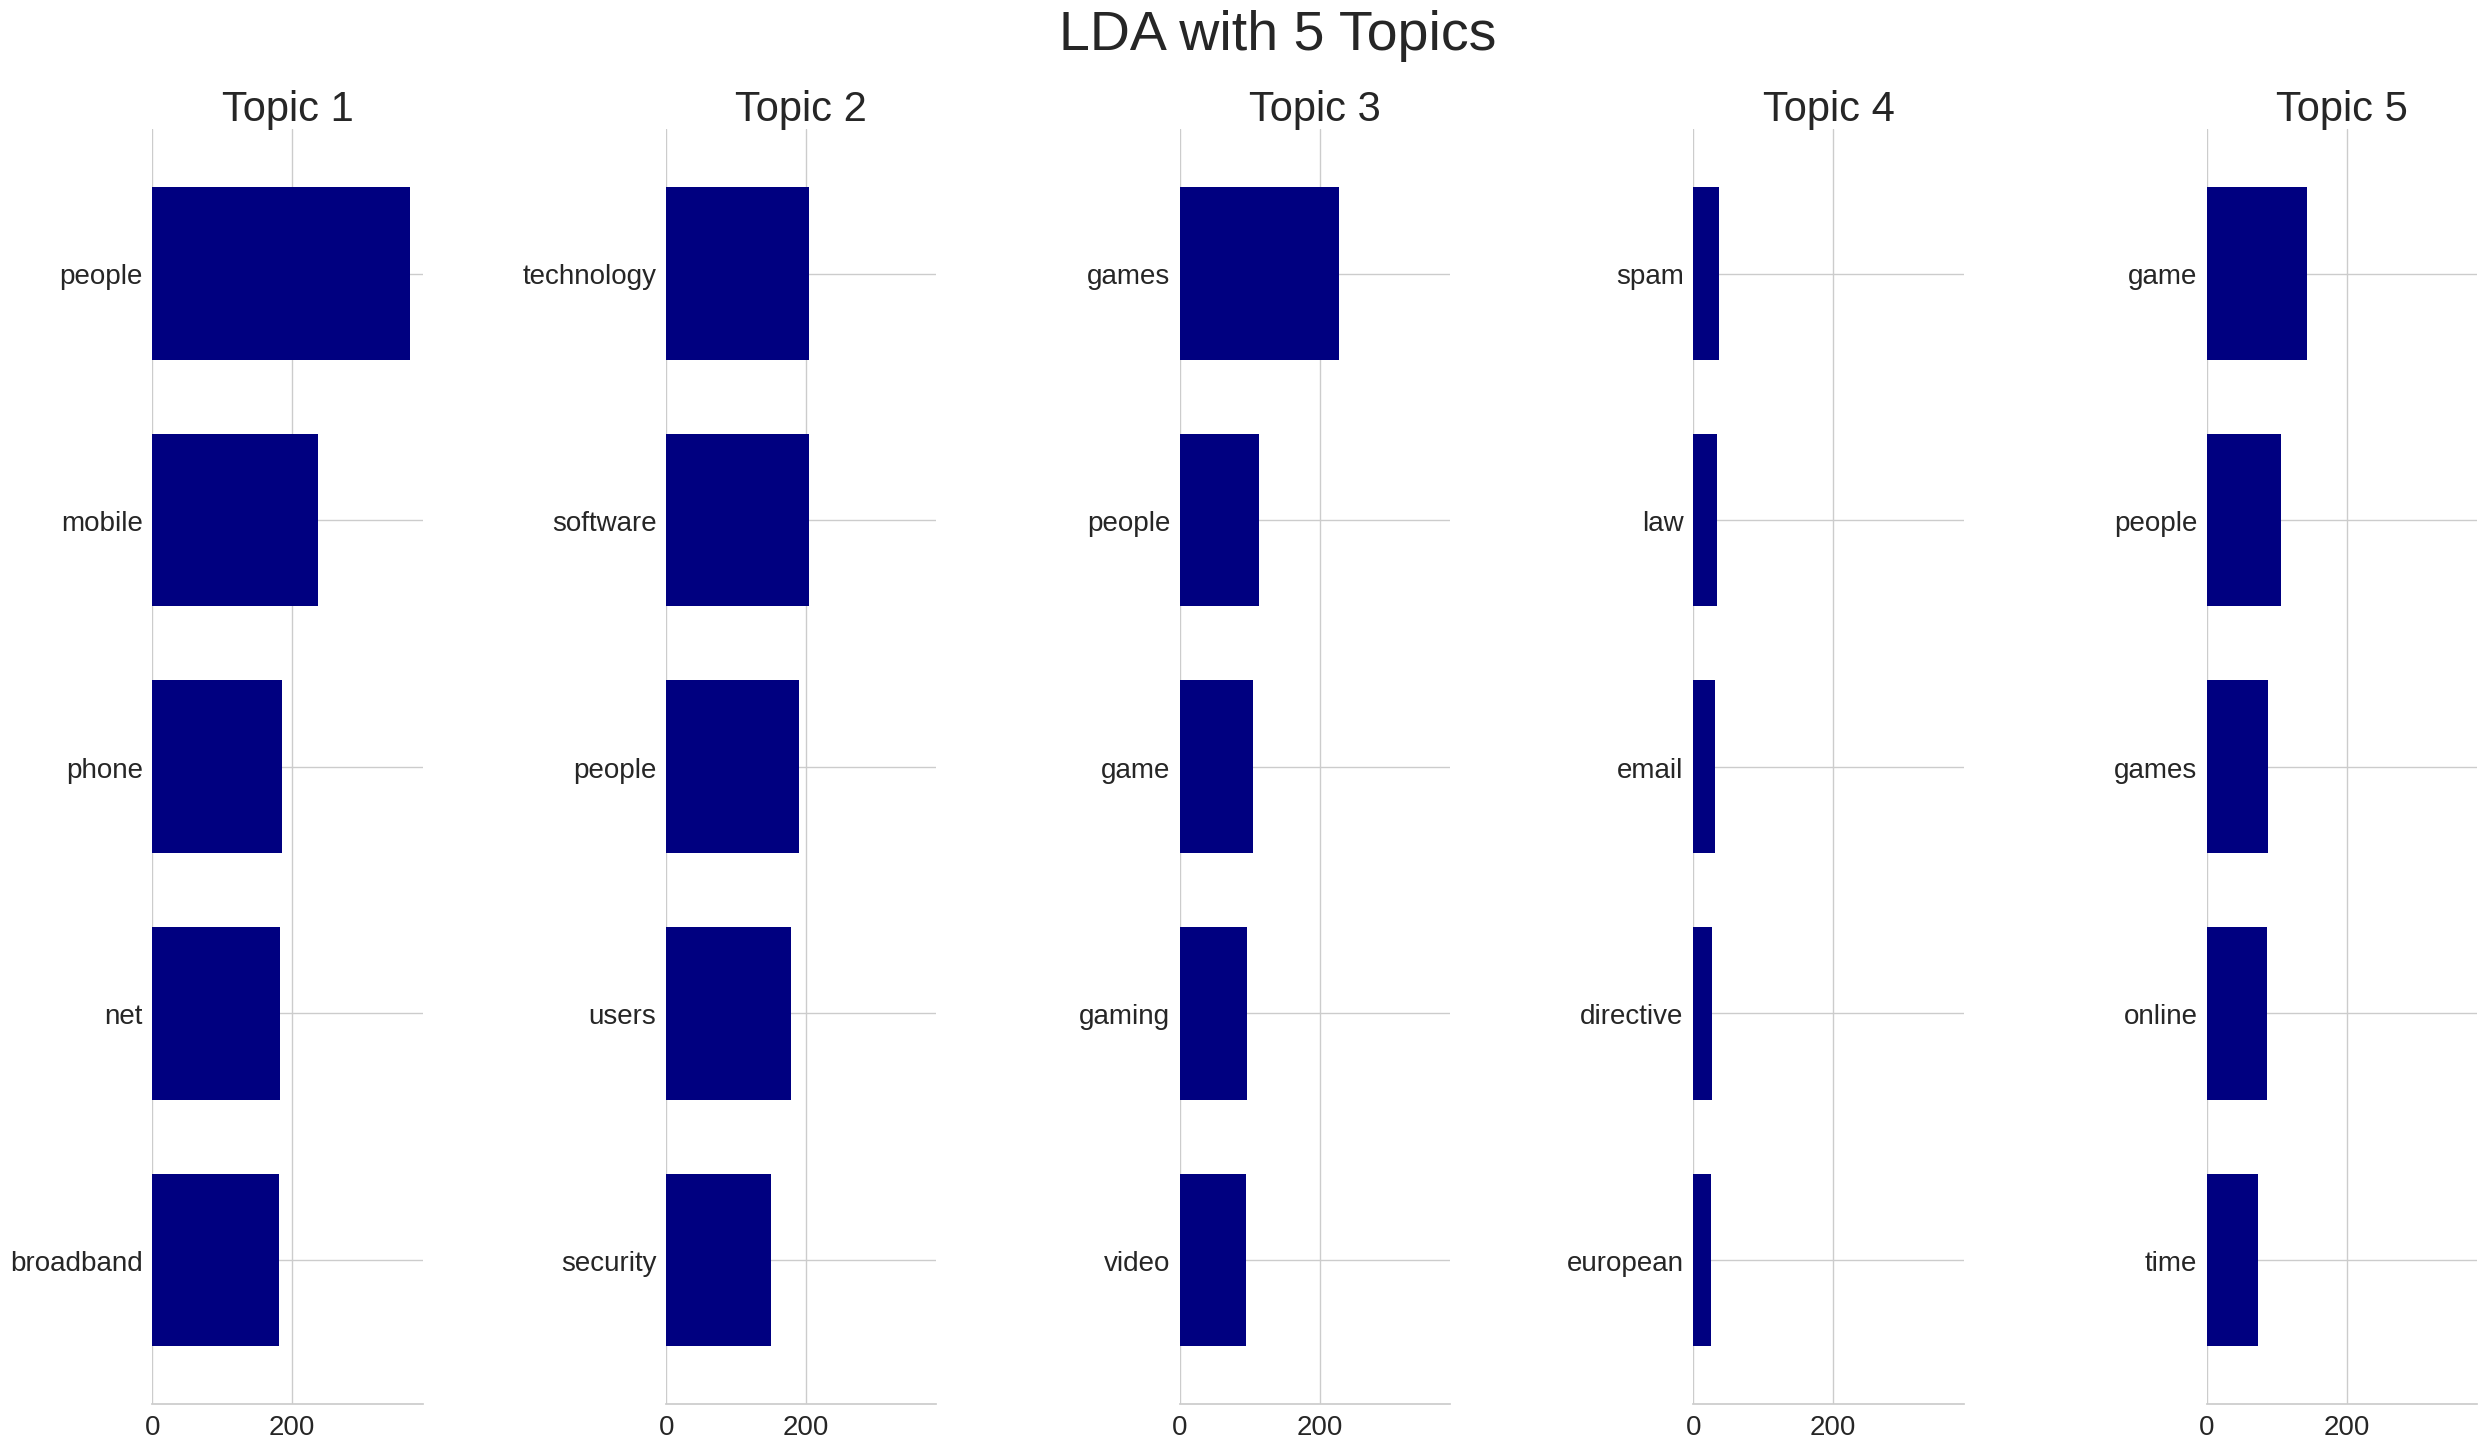

In [64]:
data_tech = data.loc[data.labels == 'tech']

common_words = ['new','one','could','also','would']

data_tech['clean text'] = data_tech['clean text'].apply(text_cleaning)

vect_tech = vectorizer.fit_transform(data_tech['clean text'])

LDA_text(vect_tech,'navy',5)

---

# References

1. [*BBC NEWS Classification (CountVectorizer & CNNs)*](https://www.kaggle.com/code/jacopoferretti/bbc-news-classification-countvectorizer-cnns), Jacopo Ferretti, notebook on Kaggle.
2. [*BBC NEWS (Text Complexity & Text Summarization)*](https://www.kaggle.com/code/jacopoferretti/bbc-news-text-complexity-text-summarization), Jacopo Ferretti, notebook on Kaggle.
3. [*AMAZON Reviews (Topics w/ Bertopic+Clusters+LDA)*](https://www.kaggle.com/code/jacopoferretti/amazon-reviews-topics-w-bertopic-clusters-lda), Jacopo Ferretti, notebook on Kaggle.
4. [NLP - EDA, Bag of Words, TF IDF, GloVe, BERT](https://www.kaggle.com/code/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert), Vitalii Mokin, notebook on Kaggle.
5. [*Topic Modelling using BERTopic*](https://www.kaggle.com/code/roryholmes96/topic-modelling-using-bertopic), Rory Holmes, notebook on Kaggle.